This is where I am planning the ananlysis of the Science Library data set. I'll make a mark-down comment block with each of my questions/hypotheses and then we will find the answers and graph the results. This analysis will be focused on the statistics of the books in the collection. 

In [75]:
##all my imports are up here
import pandas as pd 
import matplotlib.pyplot as plt
import string

#open file
file_name="Sciences_Library.xlsx"
data=pd.read_excel(file_name)

#list columns for easy reference
print(data.columns.tolist())

['Title Control Number', 'Catalog Key', 'Call Sequence', 'Copy Number', 'Format', 'Pub Year', 'BLvl', 'Type', 'Bib Form', 'Type/Form', 'Language', 'MARC key', 'Author', 'Title', 'Library', 'Call Number', 'Shelving Key', 'Class code (LC, SUDOC, NLM)', 'Call Number Range Key', 'Item Created Date', 'Item ID', 'Item Type', 'Home Location', 'Current Location', 'Item Category 1', 'Item Category 2', 'Cataloging department code', 'Cataloging Staff Code', 'Cataloging date code', 'Place of Publication (260a)', 'Publisher (260b)', 'Date of Publication (260c)', 'ISSN', 'ISBN', 'GMD (245h)', 'OCLC', 'Title Created Date', 'Title Cataloged Date', 'Created By', 'Pagination (300a)', 'Illustrations (300b)', 'Size (300c)', 'Total Charges', 'In-House Charges', 'Date Last Charged', 'Last Activity Date']


How many books are in the collection? 

In [76]:
#count all the unique title control numbers
unique_books_count = data['Title Control Number'].nunique()
print(f"Number of unique books: {unique_books_count}")

Number of unique books: 25790


Show a pie chart of the most common places of publication.

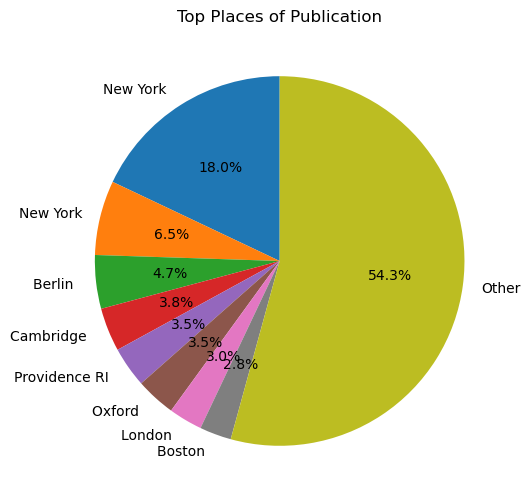

In [77]:
#use Place of Publication (260a)
#group by 'Place of Publication (260a)' and count occurrences

# Clean 'Place of Publication (260a)' column by stripping whitespace and punctuation
#I learned I needed this because my code did not work without it!
data['Place of Publication (260a)'] = data['Place of Publication (260a)'].str.strip()
data['Place of Publication (260a)'] = data['Place of Publication (260a)'].str.translate(str.maketrans('', '', string.punctuation))

# Filter out rows with missing, empty, or invalid 'Place of Publication (260a)'
#I learned I needed this because my code did not work without it!
filtered_data = data[data['Place of Publication (260a)'].notna()]
filtered_data = filtered_data[filtered_data['Place of Publication (260a)'] != '']

# Group by 'Place of Publication (260a)' and count occurrences
publication_counts = filtered_data['Place of Publication (260a)'].value_counts()

# Get the top 8 most common publication places
top_8 = publication_counts.head(8)

# Sum the rest as "Other"
other_count = publication_counts.iloc[8:].sum()

# Create a new Series for the pie chart using pd.concat
pie_data = pd.concat([top_8, pd.Series({'Other': other_count})])

# Plot the pie chart
plt.figure(figsize=(8, 6))
pie_data.plot.pie(autopct='%1.1f%%', startangle=90, legend=False)
plt.title('Top Places of Publication')
plt.ylabel('')  #we don't need this
plt.show()



What authors appear most often in the colelction? List the top 5

In [62]:
#This time I have learned my lesson and will start by stripping whitespace and punctuation and then converting everything to upper case
#We don't want to miss any instances of the same Author

#remove blank spaces or NA values
data = data[data['Author'].notna()]  # Remove NaN values
data = data[data['Author'].str.strip() != '']  # Remove blank entries

# Clean non-empty'Author' column
data['Author'] = data['Author'].str.strip()  # Strip whitespace
data['Author'] = data['Author'].str.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
data['Author'] = data['Author'].str.upper()  # Convert to uppercase
data['Author'] = data['Author'].str.replace(r'\d+', '', regex=True)# Some of them also had numbers in them


# Count occurrences of each author
author_counts = data['Author'].value_counts()

# Get the top 5 most common authors
top_5_authors = author_counts.head(5)

# Display the result
print("Top 5 authors in the collection:")
print(top_5_authors)

Top 5 authors in the collection:
Author
BOURBAKI NICOLAS                        63
LANG SERGE                              46
KNUTH DONALD ERVIN                      37
FEYNMAN RICHARD P RICHARD PHILLIPS      32
KRANTZ STEVEN G STEVEN GEORGE           28
Name: count, dtype: int64


What percentage of books in the collection are illustrated?

In [63]:
#There is some variation in the recordings in the illustration table. Some of them describe partially/fully or the size of the illustrations.
#So we will be counting books with any illlustration whatsoever, any non-empty entry
total_books = data.shape[0]

# Filter for books with a non-empty 'Illustrations (300b)' column
illustrated_books = data[data['Illustrations (300b)'].notna()]
illustrated_books = illustrated_books[illustrated_books['Illustrations (300b)'].str.strip() != '']

# Calculate the percentage
illustrated_percentage = (illustrated_books.shape[0] / total_books) * 100
print(f"Percentage of the collection that is illustrated: {illustrated_percentage:.2f}%")

Percentage of the collection that is illustrated: 79.45%


What percentage of books are currently in their home location? (home location and current location match)

In [64]:
# Filter for books where 'Home Location' entry matches 'Current Location'entry
home_location_books = data[data['Home Location'] == data['Current Location']]

# Calculate the percentage of matching
home_location_percentage = (home_location_books.shape[0] / total_books) * 100
print(f"Percentage of books currently in their home location: {home_location_percentage:.2f}%")


Percentage of books currently in their home location: 90.87%


Let's compare the publication years vs the year the book was added to the calatog. Let's make a histogram of the time differences (in years) between the year of publication and the year the book was added to the collections.

Invalid entries found where the book was added before it was published:
      Title Control Number  Pub Year  Catalog Year
83               a15159275      2016          2015
106              a10312605      2012          2011
112               a6352758      2006          2005
118               a6905594      2008          2007
140               a8529857      2010          2009
...                    ...       ...           ...
28308            a11834470      2013          2012
28324             a8231021      2010          2009
28341            a16615363      2018          2017
28346             a6388216      2006          2005
28356            a10466691      2012          2011

[925 rows x 3 columns]


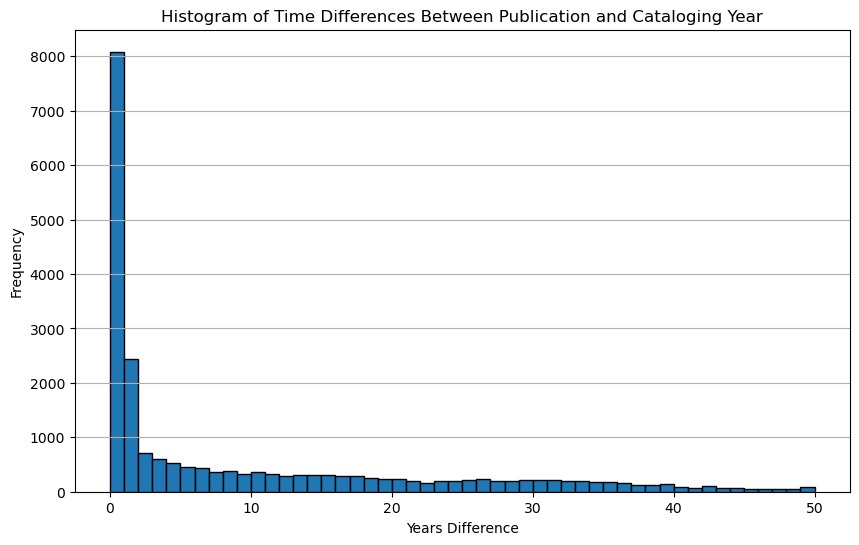

Percentage of books with a difference of 2 years or less: 50.59%


In [65]:
#First I am going to start by finding these differences between publication year and year added to the collection. 
#I'm also going to check for any invalid year combos (if the publication year is somehow after the year created) 
#If we find any erronious entries I'll print out the Title Control Numbers for affected books. 

# Ensure 'Pub Year' is non empty and numeric
data['Pub Year'] = pd.to_numeric(data['Pub Year'], errors='coerce')  
data = data[data['Pub Year'].notna()]  

# Get year and remove NaN from 'Item Created Date'
data['Catalog Year'] = pd.to_datetime(data['Item Created Date'], errors='coerce').dt.year  #turn into date-time object then get year
data = data[data['Catalog Year'].notna()]  

# Calculate the year difference
data['Year Difference'] = data['Catalog Year'] - data['Pub Year']

# Check for invalid differences
invalid_entries = data[data['Year Difference'] < 0]

#Let us know if we found any invalid entries (I was using this to de-bug)
if not invalid_entries.empty:
    # Print invalid entries with Title Control Numbers
    print("Invalid entries found where the book was added before it was published:")
    print(invalid_entries[['Title Control Number', 'Pub Year', 'Catalog Year']])
else:
    print("No invalid differences found. All data is valid.")

#We found 925 entires where the order of the dates is wrong! To check my own software,
#I am going to check some of these manually on the spreadsheet
#yeah these are legitimate and being reead correctly

#I asked my mom and she said that this happens when books are purchased before actually being published!
#The item is creatred in the catalog as soon as it has been purchased (before arrival)
#Agreed that some may be mistakes but that most would be situtations like above

##To proceed, I'll count all those differences as 0 years since that means we added the item as soon as possible
##after publication

# Replace negative year differences with 0
data['Year Difference'] = data['Year Difference'].apply(lambda x: 0 if x < 0 else x)


# Plot the difference in years in a histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(data['Year Difference'], bins=50, range=(0, 50), edgecolor='black')  # Set range and bins
plt.title('Histogram of Time Differences Between Publication and Cataloging Year')
plt.xlabel('Years Difference')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

#We found that a huge part of the collection was added within 0-2 years of its publication. 
##What percentage of books were added within two years of publication? 
# Count the books with a difference of 2 years or less

within_two_years = data[data['Year Difference'] <= 2].shape[0]
percentage_within_two_years = (within_two_years / total_books) * 100
print(f"Percentage of books with a difference of 2 years or less: {percentage_within_two_years:.2f}%")

##It's actually only 50% of the collection, you would have guessed a lot more based on the histogram but there is 
## a lot of volume in the tail. Fun statistics!

let's investogate the distribution of language for our collection as a function of time. Maybe compare in like 
2024 vs 1990 vs 1960 a pie chart of language breakdown for the collections.


Top 5 Most Popular Languages in the Collection:
eng: 98.49%
fre: 1.04%
ger: 0.38%
Top 3 Most Popular Languages in the Collection (Before 1990):
Number of books added before 1990: 0
Number of books with valid language info before 1990: 0
Top 5 Most Popular Languages in the Collection (2004 or Earlier):
eng: 97.42%
fre: 1.74%
ger: 0.70%


/var/folders/65/30_f7dm94hqcj3bkp85xhj4c0000gn/T/ipykernel_52210/341643869.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2004['Language'] = data_2004['Language'].str.strip()


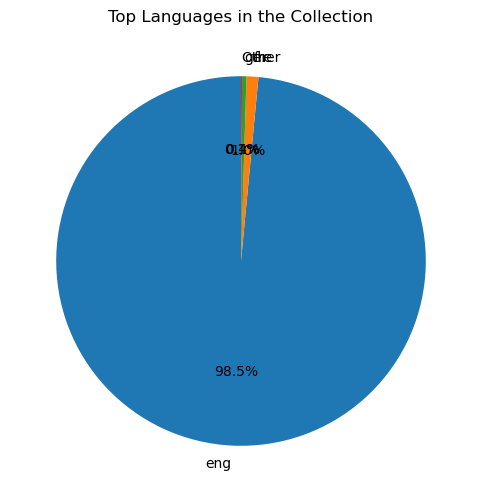

In [74]:
##let's investogate the language for our collection as a function of time. maybe compare in like 
##2024 vs 1990 vs 1979 a pie chart of language breakdown for the collections.

# Filter out rows with missing or empty 'Language' entries
data['Language'] = data['Language'].str.strip()
filtered_data = data[data['Language'].notna()]
filtered_data = filtered_data[filtered_data['Language'] != '']

# Group by 'Language' and count occurrences
language_counts = filtered_data['Language'].value_counts()

# Get the top 3
top_3_languages = language_counts.head(3)

# Sum the rest as "Other"
other_count = language_counts.iloc[3:].sum()

# Create a new Series for the pie chart
pie_data = pd.concat([top_3_languages, pd.Series({'Other': other_count})])

# Plot the pie chart
plt.figure(figsize=(8, 6))
pie_data.plot.pie(autopct='%1.1f%%', startangle=90, legend=False)
plt.title('Top Languages in the Collection')
plt.ylabel('')  # Remove the ylabel for cleaner visualization
##plt.show()

##Looking at the pie chart,, it is obvious our collection is mostly in English. Since this is not a great way to see
## (we can't even see the labels here) let's just print out a list with the top 5 languages and respective percentages for each year
# Clean and process the 'Language' column
data['Language'] = data['Language'].str.strip()  
filtered_data = data[data['Language'].notna()]  
filtered_data = filtered_data[filtered_data['Language'] != ''] 

#Do the counting
language_counts = filtered_data['Language'].value_counts()

# Get the total number of books with any valid language info
total_books_with_language = language_counts.sum()

# Get the top 5 most common languages and their percentages
top_3_languages = language_counts.head(3)
top_3_percentages = (top_3_languages / total_books_with_language) * 100

# Print the results
print("Top 5 Most Popular Languages in the Collection:")
for language, percentage in top_3_percentages.items():
    print(f"{language}: {percentage:.2f}%")


##NOW I AM GOING TO REPEAT VERY SIMILAR CODE TO FIND THE HISTORIC LANGUAGE BREAKDOWN IN 1990 AND 1960 AND PRIOR


# Ensure 'Item Created Date' is a valid datetime and extract the year
data['Item Created Year'] = pd.to_datetime(data['Item Created Date'], errors='coerce').dt.year

# Filter data for books added before 1990
data_1990 = data[data['Item Created Year'] < 1990]


data_1990['Language'] = data_1990['Language'].str.strip()  
filtered_data_1990 = data_1990[data_1990['Language'].notna()]  
filtered_data_1990 = filtered_data_1990[filtered_data_1990['Language'] != '']  


language_counts_1990 = filtered_data_1990['Language'].value_counts()

total_books_with_language_1990 = language_counts_1990.sum()

top_5_languages_1990 = language_counts_1990.head(5)
top_5_percentages_1990 = (top_5_languages_1990 / total_books_with_language_1990) * 100

print("Top 3 Most Popular Languages in the Collection (Before 1990):")
for language, percentage in top_5_percentages_1990.items():
    print(f"{language}: {percentage:.2f}%")
print(f"Number of books added before 1990: {data_1990.shape[0]}")
print(f"Number of books with valid language info before 1990: {filtered_data_1990.shape[0]}")

##There is no data all the way back to 1990! These must be newer books. Let's find the oldest book in the collection
# Ensure 'Item Created Date' is a valid datetime and extract the year
data['Item Created Year'] = pd.to_datetime(data['Item Created Date'], errors='coerce').dt.year

# Find the earliest year
earliest_year = data['Item Created Year'].min()

# Find the book(s) corresponding to the earliest year
earliest_books = data[data['Item Created Year'] == earliest_year]

# Display the results
##print(f"The earliest book(s) in the collection was added in the year {earliest_year}:")
##print(earliest_books[['Title Control Number', 'Item Created Year', 'Title', 'Author']])

##The "oldest book" is a 10,093 way tie of all the books added in 2000. So lets do our year comparsion idea for 2004 instead of 1990
##should have a decent amount in the collection by 2004

# Filter data for books added in 2004 or earlier
data_2004 = data[data['Item Created Year'] <= 2004]

# Clean and process 
data_2004['Language'] = data_2004['Language'].str.strip()  
filtered_data_2004 = data_2004[data_2004['Language'].notna()] 
filtered_data_2004 = filtered_data_2004[filtered_data_2004['Language'] != ''] 

# Count occurrences
language_counts_2004 = filtered_data_2004['Language'].value_counts()

# Get the valid total
total_books_with_language_2004 = language_counts_2004.sum()

# Get the top 5
top_3_languages_2004 = language_counts_2004.head(3)
top_3_percentages_2004 = (top_3_languages_2004 / total_books_with_language_2004) * 100

# Print
print("Top 3 Most Popular Languages in the Collection (2004 or Earlier):")
for language, percentage in top_3_percentages_2004.items():
    print(f"{language}: {percentage:.2f}%")


##NOTE: this returns a warning about editing the data frame since we used the original instead of making a copy
##It is just a warning not an error, table still prints fine. 

In [ ]:
##